# Checkin

In [1]:
import pandas as pd
import numpy as np
import utils, plot_help
import matplotlib.pyplot as plt

#avoid warning popping up
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

In [2]:
df = utils.chunk_loader(directory='data/checkin.json', c_size=50_000, read_limit=-1)

In [3]:
df.head()

,business_id,date
0,--1UhMGODdWsrMastO9DZw,"2016-04-26 19:49:16, 2016-08-30 18:36:57, 2016..."
1,--6MefnULPED_I942VcFNA,"2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012..."
2,--7zmmkVg-IMGaXbuVd0SQ,"2014-12-29 19:25:50, 2015-01-17 01:49:14, 2015..."
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,"2010-06-26 17:39:07, 2010-08-01 20:06:21, 2010..."


In [4]:
df.tail()

,business_id,date
161945,zzvlwkcNR1CCqOPXwuvz2A,"2017-05-06 20:05:15, 2017-05-12 22:37:03, 2017..."
161946,zzwaS0xn1MVEPEf0hNLjew,"2010-02-16 02:09:56, 2010-07-05 05:40:48, 2010..."
161947,zzwhN7x37nyjP0ZM8oiHmw,"2016-03-06 13:27:02, 2016-03-09 00:41:53, 2016..."
161948,zzwicjPC9g246MK2M1ZFBA,"2012-09-22 00:26:15, 2012-09-23 20:12:00, 2012..."
161949,zzzaIBwimxVej4tY6qFOUQ,"2012-10-12 16:26:35, 2012-10-19 19:31:14, 2012..."


In [5]:
#quick check if the leading -- is a typo
len(df[df['business_id'].str.contains('--')])

814

In [6]:
df.shape

(161950, 2)

In [7]:
df.dtypes

business_id    object
date           object
dtype: object

In [8]:
df.isna().mean()

business_id    0.0
date           0.0
dtype: float64

In [9]:
df.business_id.nunique()

161950

In [10]:
df['date'][1][:100]

'2011-06-04 18:22:23, 2011-07-23 23:51:33, 2012-04-15 01:07:50, 2012-05-06 23:08:42, 2012-06-08 22:43'

#### To Do List

Each business has a list of checkins stored as strings associated to it. It makes more sense to transform the data into an event log where the time stamp is the index and the business ID is a feature:



| date | Business_id   |
|------|------|
|   2011-06-04 18:22:23  | 123aAdf|
|2011-07-23 23:51:33|--6MefnULPED_I942VcFNA|


## Event Log

In [11]:
#create dict that maps ID
bus_to_check = {}

for bus, dates in zip(df['business_id'], df['date']):
    dates_as_list = dates.split(',')
    bus_to_check[bus] = pd.to_datetime(dates_as_list)
    

In [12]:
#quick check
type(bus_to_check['--1UhMGODdWsrMastO9DZw'][0])

pandas._libs.tslibs.timestamps.Timestamp

Source for dict keys that point to list:
[http://code.activestate.com/recipes/415100-invert-a-dictionary-where-values-are-lists-one-lin/](http://code.activestate.com/recipes/415100-invert-a-dictionary-where-values-are-lists-one-lin/)

### Note: Python dictionaries must have unique keys, if the data is not granular enough then we will have duplicate keys and the fuction below will not work. 

In [13]:
check_to_bus = dict( (v,k) for k in bus_to_check for v in bus_to_check[k] )

### Alternatively we define a function that returns 2 congruent lists to sidestep this issue.

In [14]:
def make_event_lists (bus_to_date):
    """
    returns two congruent lists for a dict of lists
    bus_to_date(dict): a dictionary of lists
    """
    #list containers
    date_list = []
    key_list = []
    
    #iterate over each key
    for key in bus_to_date:
        #iterate over every item in list
        for event in bus_to_date[key]:
            #append in parallel everytime we come across a value
            key_list.append(key)
            date_list.append(event)
            
    return date_list, key_list

In [15]:
#create dataframe from dict
event_df = pd.DataFrame.from_dict(check_to_bus, orient='index', columns=['business_id'])
#sort by the index
event_df = event_df.sort_index(ascending=True)
event_df.head()

,business_id
2010-01-15 22:59:12,FaHADZARwnY4yvlvpnsfGA
2010-01-15 23:29:06,3KTY5XZfavc85u0_rLFHrw
2010-01-15 23:42:01,t-o_Sraneime4DDhWrQRBA
2010-01-16 00:54:25,Z2fCgJdvjhZVP34V86UKCg
2010-01-16 02:02:04,qwvpcuHVkOM8UoyfXmdIBA


In [16]:
event_df.shape

(18012020, 1)

In [17]:
#save the work
event_df.to_csv('data/cleaned/checkin_eventlog.csv')

In [18]:
#comment this out if working with full data
#event_df = event_df.sample(n=10_000)

## Count Events

In [19]:
#count number of checkins
event_df_count = event_df['business_id'].value_counts()

In [20]:
event_df_count.describe()

count    161160.000000
mean        111.764830
std         692.633997
min           1.000000
25%           4.000000
50%          16.000000
75%          61.000000
max      133247.000000
Name: business_id, dtype: float64

In [21]:
event_df_count.max()

133247

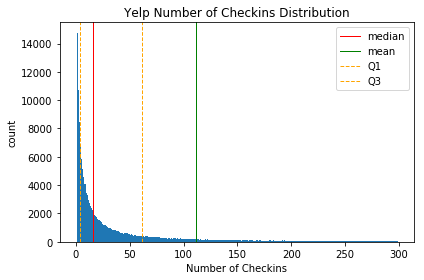

In [22]:
plot_help.plot_hist(event_df_count, end=300, step=1,
                    xlabel='Number of Checkins', feature='Number of Checkins',
                    saveloc='plots/checkin_count.png')

In [23]:
#get count of businesses with more than 1000 checkins
len(event_df_count[event_df_count.values>1000])

3072

We have business that are outliers and have so many checkins that they skew the data. We can make use of [Tukey's Method](https://www.stat.cmu.edu/~cshalizi/statcomp/13/labs/05/lab-05.pdf) to remove outliers. The convenince of the method is that it makes no assumptions about the distribution of the data

In [24]:
#calculate interquartile range
iqr = event_df_count.describe()['75%'] - event_df_count.describe()['25%']
iqr_min = event_df_count.describe()['25%'] - 1.5*iqr
iqr_max = event_df_count.describe()['75%'] + 1.5*iqr

print("IQR = {}".format(iqr))
print("Upper bound = {}".format(iqr_max))
print("Lower bound = {}".format(iqr_min))

IQR = 57.0
Upper bound = 146.5
Lower bound = -81.5


In [25]:
event_df_count_tuk = event_df_count[event_df_count.between(iqr_min, iqr_max)]

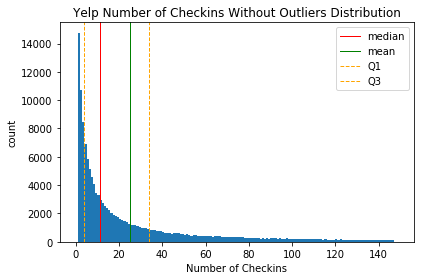

In [26]:
plot_help.plot_hist(event_df_count_tuk, end=150, step=1,
                    xlabel='Number of Checkins', feature='Number of Checkins Without Outliers',
                    saveloc='plots/checkin_count_tukey.png')

## Date of Most Recent Checkin

In [27]:
#convert index to column
event_df_max = event_df.reset_index(level=0, inplace=False)

#take most recent date
event_df_max = event_df_max.groupby(event_df_max.business_id, as_index=False).max()


#check output
event_df_max.head()

,business_id,index
0,--1UhMGODdWsrMastO9DZw,2017-05-03 17:58:02
1,--6MefnULPED_I942VcFNA,2018-10-21 22:58:14
2,--7zmmkVg-IMGaXbuVd0SQ,2018-11-03 17:22:03
3,--8LPVSo5i0Oo61X01sV9A,2016-07-08 16:43:30
4,--9QQLMTbFzLJ_oT-ON3Xw,2018-06-16 18:44:45


In [28]:
#save the work
event_df_max.to_csv('data/cleaned/event_df_max.csv')

## Events Over Time

In [29]:
checkin_year = event_df.groupby(pd.Grouper(freq='Y')).count()
checkin_year

,business_id
2010-12-31,388202
2011-12-31,1550845
2012-12-31,2124681
2013-12-31,2506988
2014-12-31,2573504
2015-12-31,2595060
2016-12-31,2406357
2017-12-31,2179140
2018-12-31,1687243


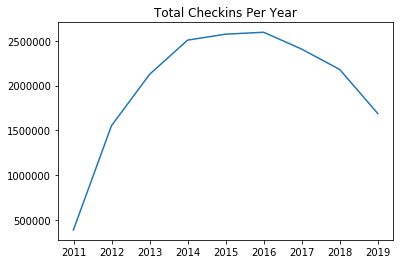

In [30]:
plt.plot(checkin_year.index, checkin_year.business_id)
plt.title("Total Checkins Per Year")
plt.savefig("plots/checkin_by_year.png")

In [31]:
checkin_day = event_df.groupby(pd.Grouper(freq='1D')).count()
checkin_day.head()

,business_id
2010-01-15,3
2010-01-16,155
2010-01-17,161
2010-01-18,139
2010-01-19,102


### Zoom in on year of 2014. Notice that peaks happen aroun the weekend

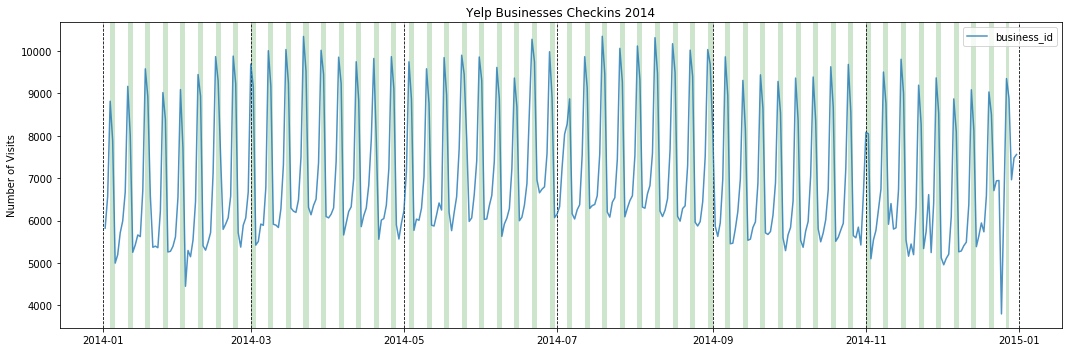

In [32]:
#get 2014-2015 date indeces
df_2014 = checkin_day[(checkin_day.index>'2014-01-01') & (checkin_day.index<'2015-01-01')]
#plot
plot_help.plot_datetime(df_2014, 
                        title='Yelp Businesses Checkins 2014', 
                        saveloc='plots/checkin_2014.png')

### Zoom in on April 2014 as sample

In [33]:
df_2014_april = checkin_day[(checkin_day.index>'2014-04-01') & (checkin_day.index<'2014-05-01')]

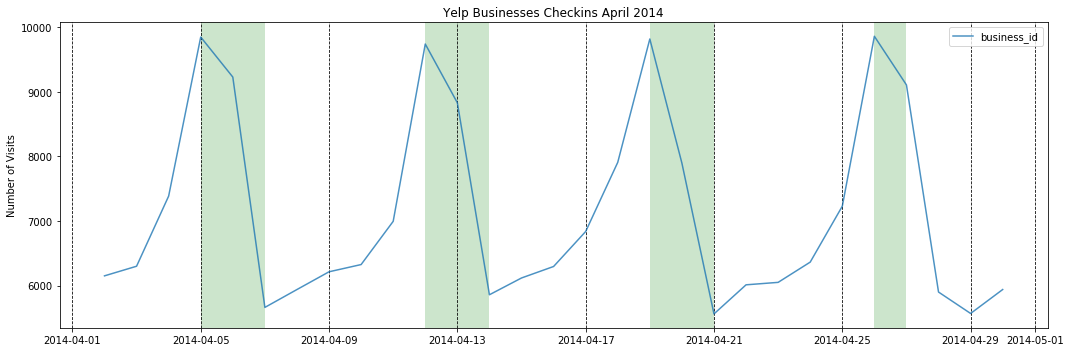

In [34]:
plot_help.plot_datetime(df_2014_april, 
                        title='Yelp Businesses Checkins April 2014', 
                        saveloc='plots/checkin_2014_april.png')

### Compare to holiday month of December

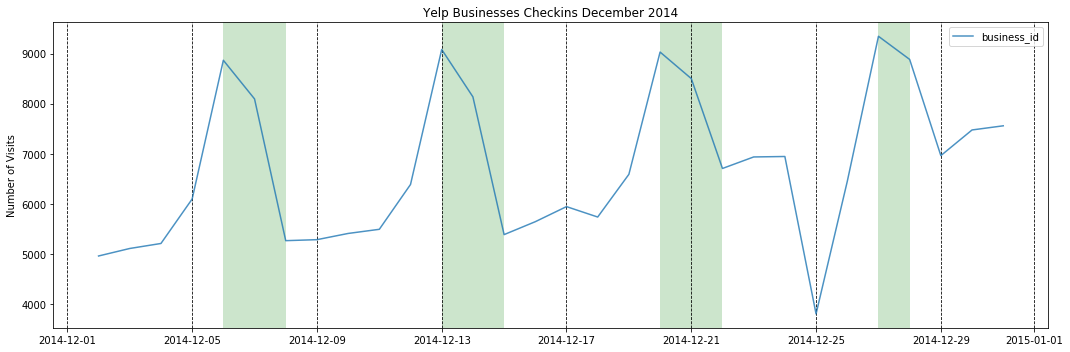

In [35]:
df_2014_december = checkin_day[(checkin_day.index>'2014-12-01') & (checkin_day.index<'2015-01-01')]

plot_help.plot_datetime(df_2014_december, 
                        title='Yelp Businesses Checkins December 2014', 
                        saveloc='plots/checkin_2014_december.png')

### Increase granularity by picking random week of 2014 with 30min intevals

In [36]:
checkin_halfhour = event_df.groupby(pd.Grouper(freq='30min')).count()

In [37]:
checkin_halfhour.head()

,business_id
2010-01-15 22:30:00,1
2010-01-15 23:00:00,1
2010-01-15 23:30:00,1
2010-01-16 00:00:00,0
2010-01-16 00:30:00,1


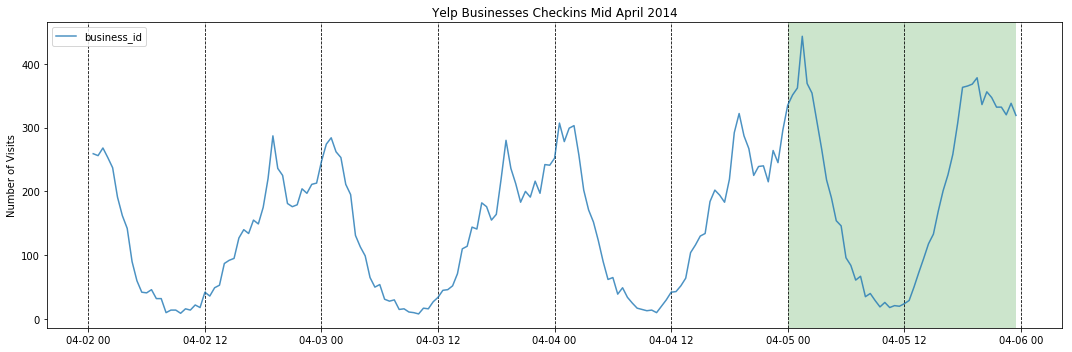

In [38]:
checkin_halfhour_midapril = checkin_halfhour[(checkin_halfhour.index>'2014-04-02 00:00:00')
                                             & (checkin_halfhour.index<'2014-04-06 00:00:00')]

plot_help.plot_datetime(checkin_halfhour_midapril,
                        title='Yelp Businesses Checkins Mid April 2014', 
                        saveloc='plots/checkin_2014_april_30min.png')

### Repeat for other random time of July

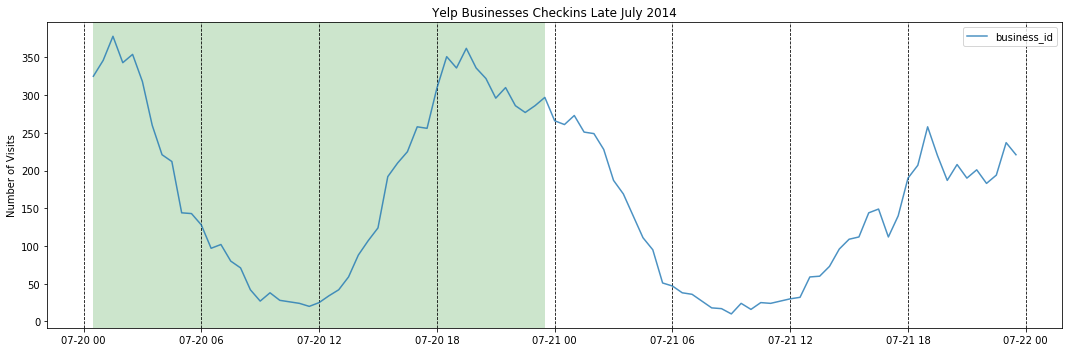

In [39]:
checkin_halfhour_midjuly = checkin_halfhour[(checkin_halfhour.index>'2014-07-20 00:00:00')
                                             & (checkin_halfhour.index<'2014-07-22 00:00:00')]

plot_help.plot_datetime(checkin_halfhour_midjuly, 
                        title='Yelp Businesses Checkins Late July 2014', 
                        saveloc='plots/checkin_halfhour_midjuly_30min.png')

## As a general obseration, most checkins tend to peak around the weekend which is defined as Saturday-Sunday. From a more granular perspective on daily basis, checkins tend to peak around 6:00PM which might be due to dinner time.

## To gain a better understanding we can group chekins by day

In [40]:
# add a column including time only
checkin_halfhour['Time']=checkin_halfhour.index.time

#column for name of day of week
checkin_halfhour['DayOfWeek'] = checkin_halfhour.index.weekday_name

checkin_halfhour.head()

,business_id,Time,DayOfWeek
2010-01-15 22:30:00,1,22:30:00,Friday
2010-01-15 23:00:00,1,23:00:00,Friday
2010-01-15 23:30:00,1,23:30:00,Friday
2010-01-16 00:00:00,0,00:00:00,Saturday
2010-01-16 00:30:00,1,00:30:00,Saturday


In [41]:
#group by day of week and aggregate by sum+mean+stf
day_avg=checkin_halfhour.groupby(['DayOfWeek','Time']).agg([np.sum, np.mean, np.std])

#drop level in colums
day_avg.columns = day_avg.columns.droplevel()

#extract upper and lower bound as mean +/- 2STD
day_avg['upper'] = day_avg['mean'] + 2*day_avg['std']
day_avg['lower'] = day_avg['mean'] - 2*day_avg['std']

#extract day of week name
day_avg['day']=day_avg.reset_index()['DayOfWeek'].tolist()

day_avg.head()

sum        mean        std       upper      lower  \
DayOfWeek Time                                                             
Friday    00:00:00   92875  201.902174  71.791131  345.484435  58.319913   
          00:30:00   99487  216.276087  78.435046  373.146180  59.405994   
          01:00:00  102484  222.791304  78.231877  379.255057  66.327551   
          01:30:00  102034  221.813043  78.483890  378.780823  64.845264   
          02:00:00   96047  208.797826  73.036509  354.870843  62.724809   

                       day  
DayOfWeek Time              
Friday    00:00:00  Friday  
          00:30:00  Friday  
          01:00:00  Friday  
          01:30:00  Friday  
          02:00:00  Friday

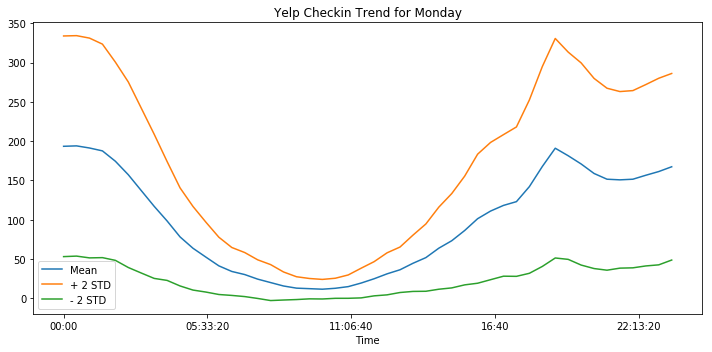

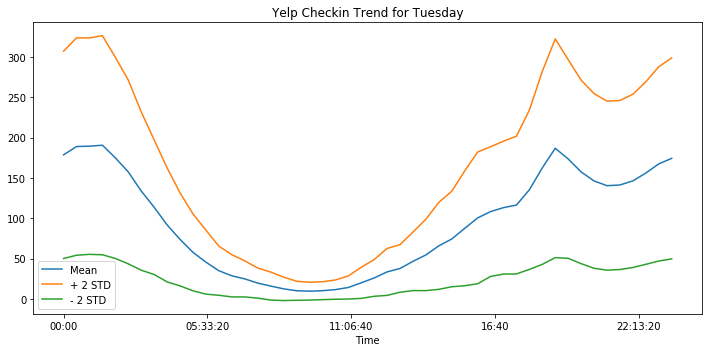

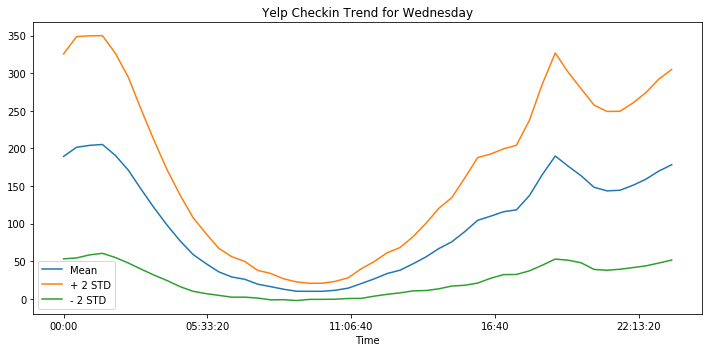

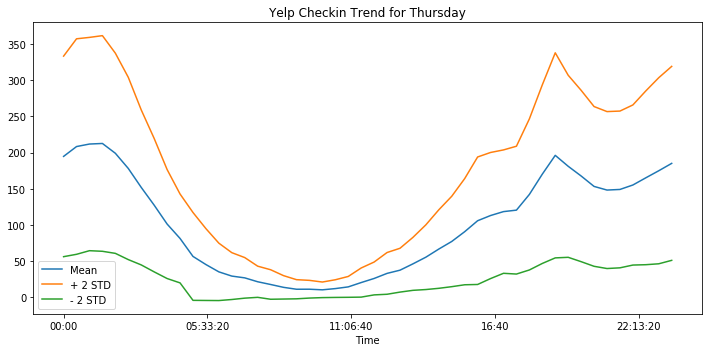

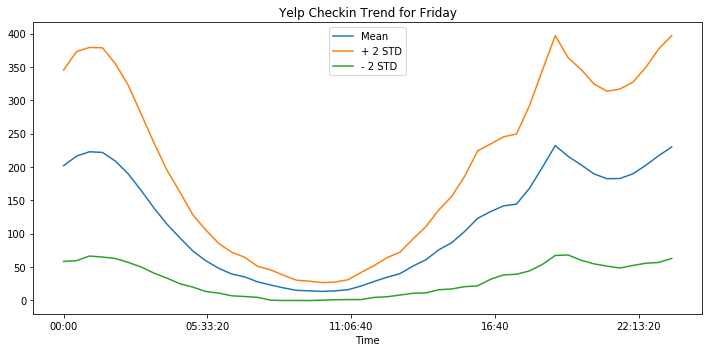

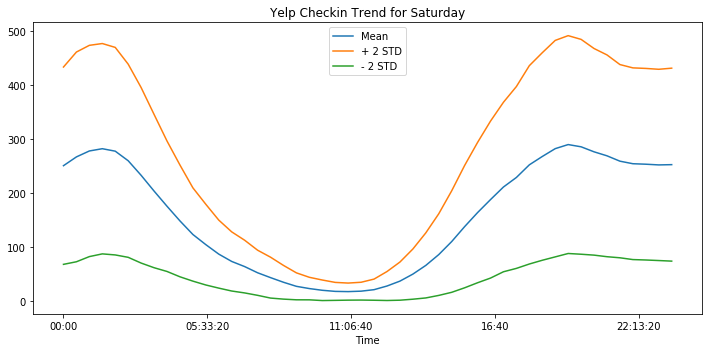

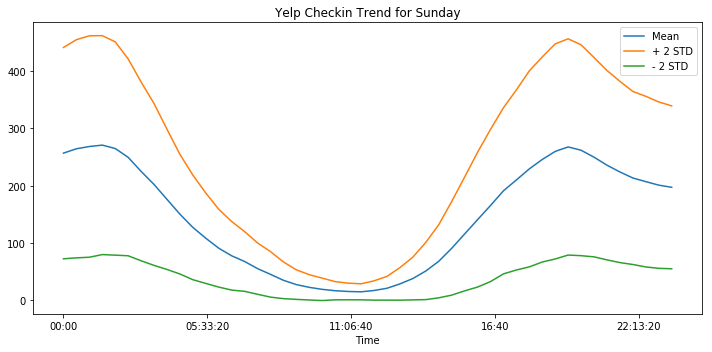

In [42]:
#days of week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for day in days:
    
    ax=day_avg[day_avg['day']==day].unstack(level=0)['mean'].plot(figsize=(10,5))
    day_avg[day_avg['day']==day].unstack(level=0)['upper'].plot(ax=ax)
    day_avg[day_avg['day']==day].unstack(level=0)['lower'].plot(ax=ax)
    ax.set_title('Yelp Checkin Trend for {}'.format(day))
    ax.legend(['Mean','+ 2 STD','- 2 STD'])
    plt.tight_layout()
    plt.savefig('plots/checkin_trend_'+day+'.png')

## Repeat exercise above but with more granular approach: Separate by business category

In [43]:
cat_type_df = utils.chunk_loader('data/cleaned/business_cats.csv', read_limit=-1)
cat_type_df.head(10)

,Restaurants,Food,Shopping,Home,Spas,Bars,Beauty,Medical,Health,Hair,business_id
0,0,0,0,0,0,0,0,0,0,0,1SWheh84yJXfytovILXOAQ
1,1,1,0,0,0,0,0,0,0,0,QXAEGFB4oINsVuTFxEYKFQ
2,1,0,0,0,0,1,0,0,0,0,gnKjwL_1w79qoiV3IC_xQQ
3,0,0,0,0,0,0,0,0,0,0,xvX2CttrVhyG2z1dFg_0xw
4,0,0,1,1,0,0,0,0,0,0,HhyxOkGAM07SRYtlQ4wMFQ
5,0,0,0,0,0,0,0,0,0,0,68dUKd8_8liJ7in4aWOSEA
6,0,0,0,0,1,0,1,0,0,1,5JucpCfHZltJh5r1JabjDg
7,0,0,1,0,1,0,1,0,0,1,gbQN7vr_caG_A1ugSmGhWg
8,0,0,0,0,1,0,1,0,0,0,Y6iyemLX_oylRpnr38vgMA
9,0,0,0,0,1,0,1,0,0,0,4GBVPIYRvzGh4K4TkRQ_rw


Divide the dataframes in 3 categories:
- Service = Restaurants + Food + Bars
- Personal = Beauty + Medical + Health + Hair + Spas
- Mall = Shopping + Home				

In [44]:
cat_df_reduce = cat_type_df.copy()
#combine types
cat_df_reduce['service'] = (cat_df_reduce['Restaurants'] + cat_df_reduce['Food']   
                             + cat_df_reduce['Bars']).apply(lambda x: min(1,x))

cat_df_reduce['personal'] = (cat_df_reduce['Beauty'] + cat_df_reduce['Medical'] +
                             cat_df_reduce['Spas'] + cat_df_reduce['Hair']  
                            ).apply(lambda x: min(1,x))

cat_df_reduce['mall'] = (cat_df_reduce['Shopping'] + cat_df_reduce['Home']).apply(lambda x: min(1,x))

cat_df_reduce= cat_df_reduce[['business_id', 'service', 'personal', 'mall']]

cat_df_reduce.head()

,business_id,service,personal,mall
0,1SWheh84yJXfytovILXOAQ,0,0,0
1,QXAEGFB4oINsVuTFxEYKFQ,1,0,0
2,gnKjwL_1w79qoiV3IC_xQQ,1,0,0
3,xvX2CttrVhyG2z1dFg_0xw,0,0,0
4,HhyxOkGAM07SRYtlQ4wMFQ,0,0,1


In [45]:
#recall proportions
cat_df_reduce.mean()

service     0.401497
personal    0.173268
mall        0.253981
dtype: float64

In [46]:
cat_df_reduce.shape

(192609, 4)

In [47]:
#left join two dataframes
event_df_cat = pd.merge(left=event_df.reset_index(level=0), #drop index to preserve it
                        right=cat_df_reduce, 
                        how='left', 
                        on='business_id')

#set index in place
event_df_cat.set_index('index', inplace=True)

event_cat_halfhour = event_df_cat.groupby(pd.Grouper(freq='30min')).sum()

# add a column including time only
event_cat_halfhour['Time']=event_cat_halfhour.index.time

#column for name of day of week
event_cat_halfhour['DayOfWeek'] = event_cat_halfhour.index.weekday_name

print(event_cat_halfhour.shape)

# add a column including time only
#event_df_cat['Time']=event_df_cat.index.time

#column for name of day of week
#event_df_cat['DayOfWeek'] = event_df_cat.index.weekday_name

event_cat_halfhour.head()

(154822, 5)


,service,personal,mall,Time,DayOfWeek
index,,,,,
2010-01-15 22:30:00,0,0,0,22:30:00,Friday
2010-01-15 23:00:00,1,0,0,23:00:00,Friday
2010-01-15 23:30:00,0,0,0,23:30:00,Friday
2010-01-16 00:00:00,0,0,0,00:00:00,Saturday
2010-01-16 00:30:00,1,0,0,00:30:00,Saturday


In [48]:
#group by day of week and aggregate by sum+mean+stf
event_cat_groupby = event_cat_halfhour.groupby(['DayOfWeek','Time']).agg([np.sum, np.mean, np.std])
event_cat_groupby.head()

service                        personal             \
                       sum        mean        std      sum       mean   
DayOfWeek Time                                                          
Friday    00:00:00   65385  142.141304  51.735834     7022  15.265217   
          00:30:00   71598  155.647826  57.434531     7104  15.443478   
          01:00:00   76767  166.884783  60.293597     6262  13.613043   
          01:30:00   77260  167.956522  60.868535     5521  12.002174   
          02:00:00   74657  162.297826  58.183097     4328   9.408696   

                               mall                        
                         std    sum       mean        std  
DayOfWeek Time                                             
Friday    00:00:00  7.168018  11883  25.832609  11.130843  
          00:30:00  7.434761  12054  26.204348  11.554625  
          01:00:00  6.278768  11433  24.854348  11.023963  
          01:30:00  5.964491  10586  23.013043  10.290330  
          02:00:00  4.674402   9525  20.706522   9.533267

In [49]:
#columns single level
event_cat_groupby.columns =event_cat_groupby.columns.map('_'.join)
event_cat_groupby.head()

service_sum  service_mean  service_std  personal_sum  \
DayOfWeek Time                                                             
Friday    00:00:00        65385    142.141304    51.735834          7022   
          00:30:00        71598    155.647826    57.434531          7104   
          01:00:00        76767    166.884783    60.293597          6262   
          01:30:00        77260    167.956522    60.868535          5521   
          02:00:00        74657    162.297826    58.183097          4328   

                    personal_mean  personal_std  mall_sum  mall_mean  \
DayOfWeek Time                                                         
Friday    00:00:00      15.265217      7.168018     11883  25.832609   
          00:30:00      15.443478      7.434761     12054  26.204348   
          01:00:00      13.613043      6.278768     11433  24.854348   
          01:30:00      12.002174      5.964491     10586  23.013043   
          02:00:00       9.408696      4.674402      9525  20.706522   

                     mall_std  
DayOfWeek Time                 
Friday    00:00:00  11.130843  
          00:30:00  11.554625  
          01:00:00  11.023963  
          01:30:00  10.290330  
          02:00:00   9.533267

In [50]:
event_cat_groupby.columns

Index(['service_sum', 'service_mean', 'service_std', 'personal_sum',
       'personal_mean', 'personal_std', 'mall_sum', 'mall_mean', 'mall_std'],
      dtype='object')

In [51]:
#select integer columns
cat_cols = cat_df_reduce.select_dtypes(int).columns

In [52]:
df_cat_conf = event_cat_groupby.copy()

for col in cat_cols:
    upper_name = col + '_upper'
    lower_name = col + '_lower'
    
    #extract upper and lower bound as mean +/- 2STD
    df_cat_conf[upper_name] = df_cat_conf[col+'_mean'] + 2*df_cat_conf[col+'_std']
    df_cat_conf[lower_name] = df_cat_conf[col+'_mean'] - 2*df_cat_conf[col+'_std']
    
#extract day of week name
df_cat_conf['day']=df_cat_conf.reset_index()['DayOfWeek'].tolist()
    
df_cat_conf.head()

service_sum  service_mean  service_std  personal_sum  \
DayOfWeek Time                                                             
Friday    00:00:00        65385    142.141304    51.735834          7022   
          00:30:00        71598    155.647826    57.434531          7104   
          01:00:00        76767    166.884783    60.293597          6262   
          01:30:00        77260    167.956522    60.868535          5521   
          02:00:00        74657    162.297826    58.183097          4328   

                    personal_mean  personal_std  mall_sum  mall_mean  \
DayOfWeek Time                                                         
Friday    00:00:00      15.265217      7.168018     11883  25.832609   
          00:30:00      15.443478      7.434761     12054  26.204348   
          01:00:00      13.613043      6.278768     11433  24.854348   
          01:30:00      12.002174      5.964491     10586  23.013043   
          02:00:00       9.408696      4.674402      9525  20.706522   

                     mall_std  service_upper  service_lower  personal_upper  \
DayOfWeek Time                                                                
Friday    00:00:00  11.130843     245.612973      38.669636       29.601254   
          00:30:00  11.554625     270.516889      40.778764       30.312999   
          01:00:00  11.023963     287.471977      46.297588       26.170579   
          01:30:00  10.290330     289.693591      46.219453       23.931157   
          02:00:00   9.533267     278.664020      45.931632       18.757499   

                    personal_lower  mall_upper  mall_lower     day  
DayOfWeek Time                                                      
Friday    00:00:00        0.929181   48.094295    3.570923  Friday  
          00:30:00        0.573957   49.313597    3.095099  Friday  
          01:00:00        1.055508   46.902274    2.806422  Friday  
          01:30:00        0.073191   43.593704    2.432383  Friday  
          02:00:00        0.059892   39.773056    1.639988  Friday

In [53]:
df_cat_conf.columns

Index(['service_sum', 'service_mean', 'service_std', 'personal_sum',
       'personal_mean', 'personal_std', 'mall_sum', 'mall_mean', 'mall_std',
       'service_upper', 'service_lower', 'personal_upper', 'personal_lower',
       'mall_upper', 'mall_lower', 'day'],
      dtype='object')

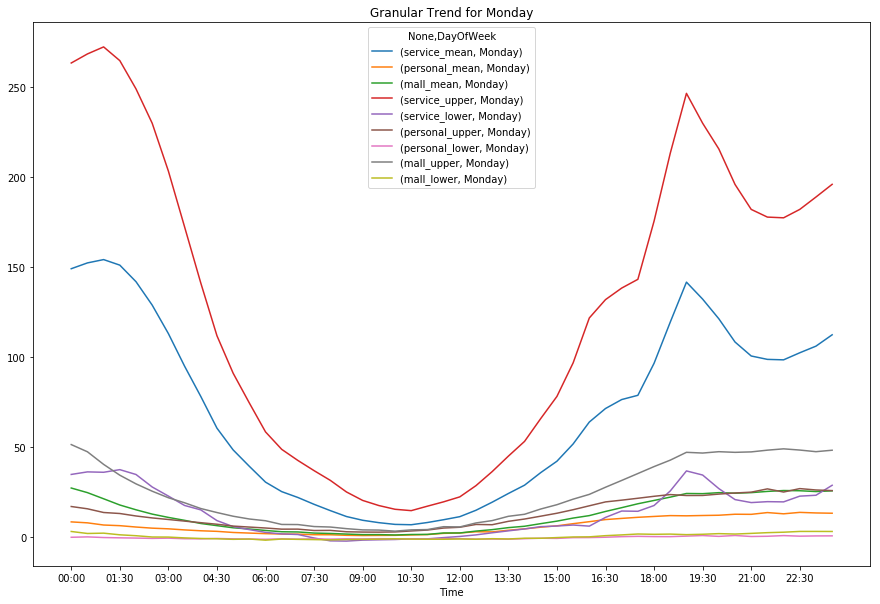

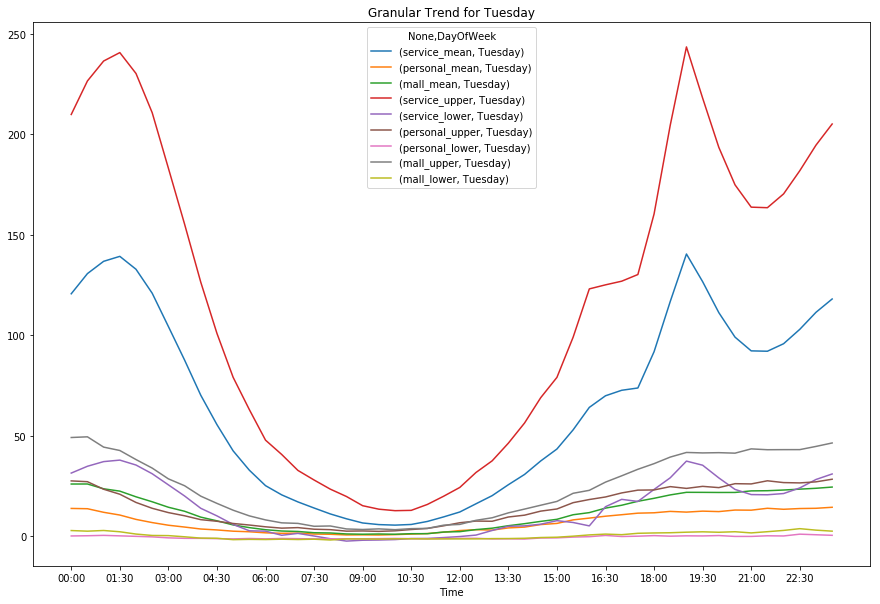

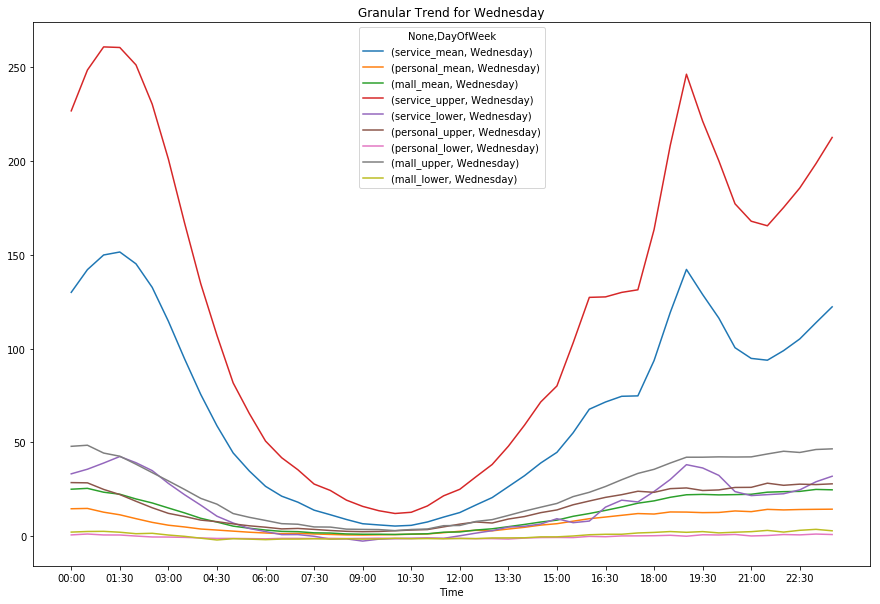

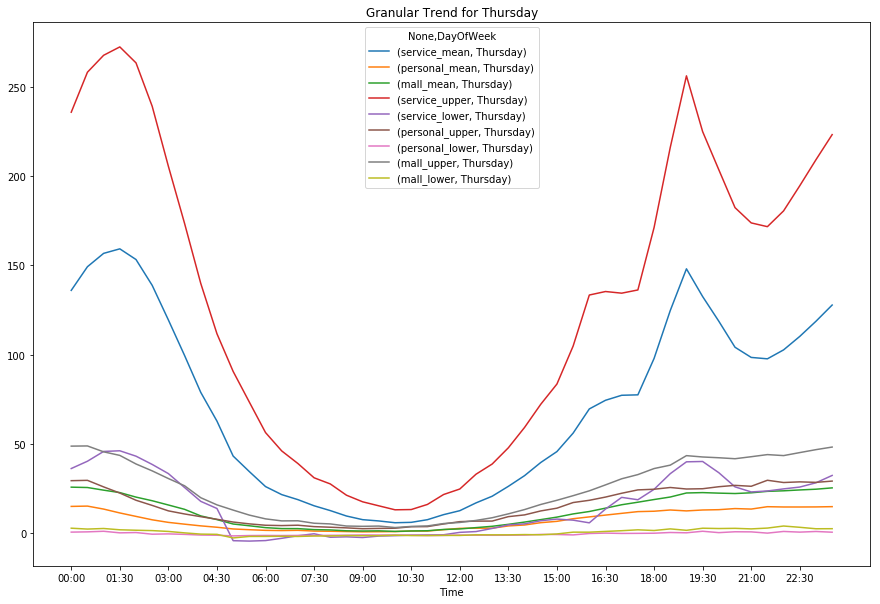

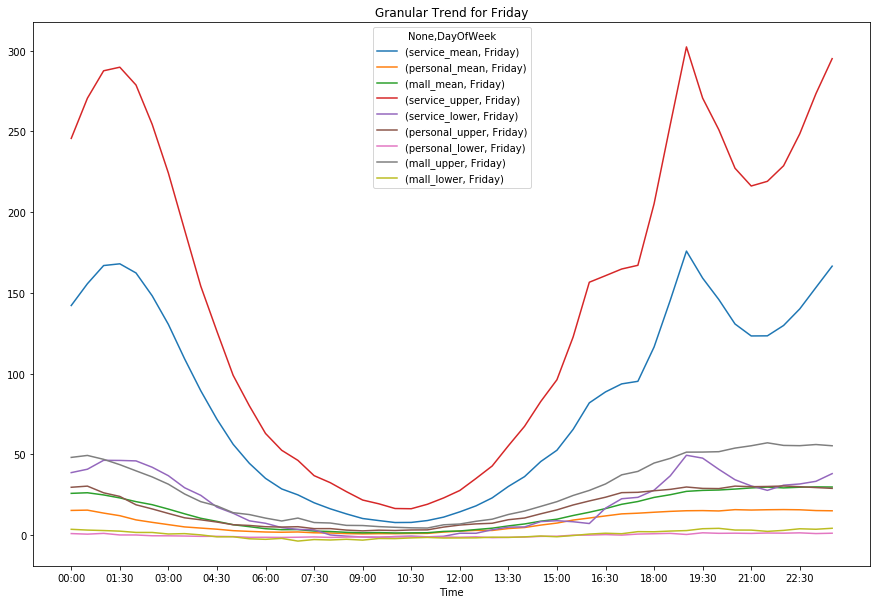

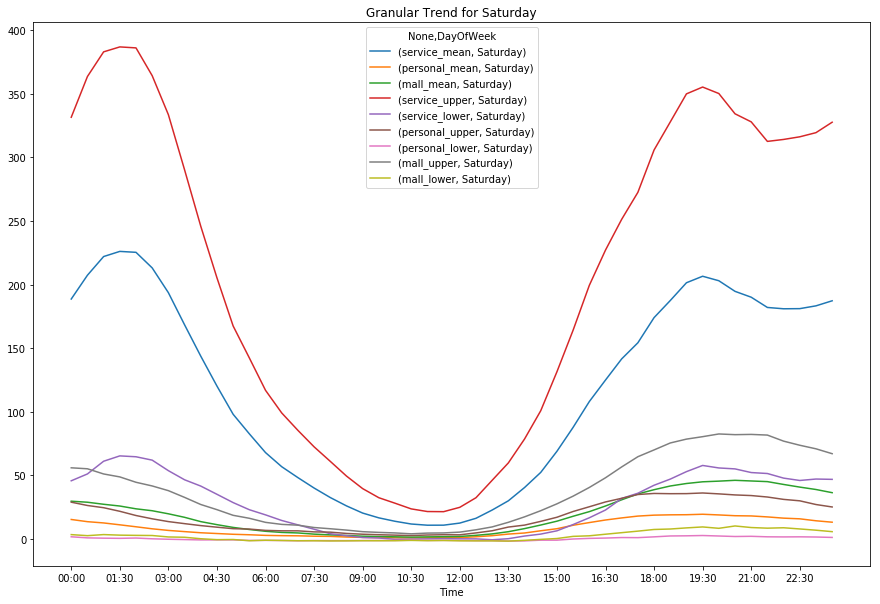

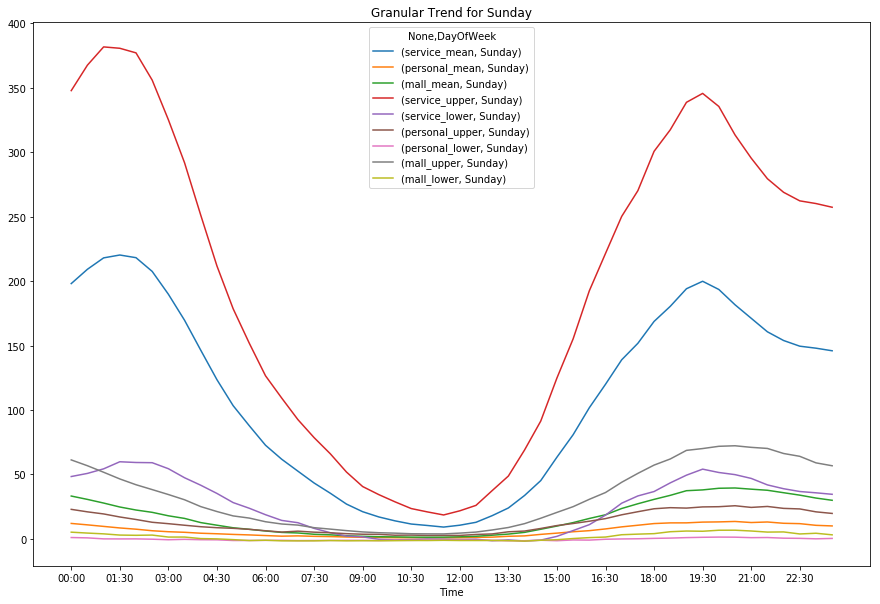

In [54]:
for day in days:
    df_cat_day = df_cat_conf[df_cat_conf['day']==day].filter(regex='lower|mean|upper').unstack(level=0)
    df_cat_day.plot(figsize=(15, 10),
                    title='Granular Trend for {}'.format(day),
                    xticks=df_cat_day.index[0::3])

### It appears that the top 3 categories follow very similar trends between each other and the global trend. The service industry has the lion's share of traffic, and all 3 are mostly active on the weekend.